<a href="https://colab.research.google.com/github/nandita992/Cycle_Gan_MRI/blob/main/Cycle_GAN_Brain_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MRI Style Transfer using CycleGAN

In this notebook, we will generate T2 MRI images from T1 MRI images and vice versa.

![T1_to_T2_conversion.png](attachment:T1_to_T2_conversion.png)

### Pipeline
The Sequence of the Notebook

1. Importing Libraries
2. Data Loading
3. Data Preprocessing
4. Model Building
5. Model Training
6. Generating a GIF

### Import Libraries

In [ ]:
# Import Required Libraries here
import tensorflow as tf
import matplotlib.pyplot as plt

### Data Loading

Resize all MRI images in our dataset to (256, 256) to maintain uniformity across the dataset

Having images size as a power of two also makes our model training faster and more accurate

In [ ]:
# Load the T1 MRI images here using tf.keras.preprocessing.image_dataset_from_directory()
tr1 = tf.keras.preprocessing.image_dataset_from_directory('/Users/ssahu/Downloads/Medical-Image-Synthesis-master/data1/Tr1',
    color_mode='grayscale', batch_size=1, label_mode=None, image_size=(256, 256), shuffle=True, seed=42, interpolation='nearest')

Found 43 files belonging to 1 classes.


In [ ]:
# Load the T2 MRI images here using tf.keras.preprocessing.image_dataset_from_directory()
tr2 = tf.keras.preprocessing.image_dataset_from_directory('/Users/ssahu/Downloads/Medical-Image-Synthesis-master/data1/Tr2',
    color_mode='grayscale', batch_size=1, label_mode=None, image_size=(256, 256), shuffle=True, seed=42, interpolation='nearest')

Found 46 files belonging to 1 classes.


### Data Preprocessing

#### Normalization of Images between [-1, 1]
Pixel Normalization with zero center

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [ ]:
def preprocess_image_train(image):
    # random flipping or mirroring to prevent overfitting
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

In [ ]:
# Using AUTOTUNE let the algorithm decide how much batches it wants to load parallely
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# apply the preprocessing on both of the datasets
tr1 = tr1.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(128)

tr2 = tr2.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(128)

#### Visulaize the data

In [ ]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

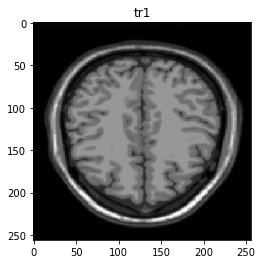

In [ ]:
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

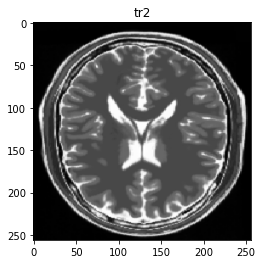

In [ ]:
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

### Model Building
1. Instance Normalization
2. Downsampling, Upsampling and Unet
3. Generator Building using Unet
4. Discriminator Building

#### Instance Normalization

In [ ]:
# Defining a class for Instance Normalization
class InstanceNormalization(tf.keras.layers.Layer):
    
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance using tf.nn.moments(), 
        # Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        
        # implement the formula (x-mean) / stddev
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        
        # return the normalized value according to the scale and offset we set earlier
        return self.scale * normalized + self.offset

#### Downsampling

In [ ]:
# define a downsampling stack here
def downsample(filters, size, apply_norm=True):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # add a 2D Convolutional layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    
    if apply_norm:
        # add an instance normalization layer here
        result.add(InstanceNormalization())
    
    # add a leaky relu activation here
    result.add(tf.keras.layers.LeakyReLU())
    return result

#### Upsampling

In [ ]:
# define upsampling stack
def upsample(filters, size, apply_dropout=False):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # add a 2D Transposed Convolution layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    
    # add an Instance Normalization layer
    result.add(InstanceNormalization())
    
    if apply_dropout:
        # add a dropout layer here
        result.add(tf.keras.layers.Dropout(0.5))
    
    # add a leaky relu activation here
    result.add(tf.keras.layers.ReLU())
    return result

#### Generator Model building using Unets

In [ ]:
# combine downstack and uptack here to build a unet generator
def unet_generator():
    # focus on how size is changing while adding one downsampling layers
    # remember that our end goal for downsampling is to reduce the size to (1,1,512) initially
    down_stack = [
        downsample(64, 4, False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4) # (bs, 1, 1, 512)
    ]
    
    # in upsampling we'll increase the size from (1,1,512)
    # our end goal in upsampling is to increase the size to (128, 128, 128)
    up_stack = [
        upsample(512, 4, True), # (bs, 2, 2, 1024)
        upsample(512, 4, True), # (bs, 4, 4, 1024)
        upsample(512, 4, True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4) # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # apply a 2D Transposed Convolution layer to upsample the data to to (256,256,1)
    # use an activation such that the values remain in range (-1,1)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    
    # now we need to build skip connections between upsampling layer and downsampling layer
    # add a concatenate layer
    concat = tf.keras.layers.Concatenate()
    # add an input layer here
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    # loop through each downsampling layer
    for down in down_stack:
        # perform one donwsampling step
        x = down(x)
        # append this output into skip connection layer
        skips.append(x)
    
    # we'll add skip connections with upsampling layers but in reverse order, hence we reverse the skip connectios list
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        # perform one step of upsampling
        x = up(x)
        # concat the current output with current skip layer to establish skip connection
        x = concat([x, skip])
    
    # perform last layer operation to achieve desired image size
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
# declare two generators of type unet_generator
generator_g = unet_generator()
generator_f = unet_generator()

#### Discriminator model building

In [ ]:
# use downsample stack to build the discriminator model
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # declare an input layer
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    
    # apply downsampling steps to achieve size of (6,6,1)
    # our aim is to build a patch of (6,6,1) as a output
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    # apply zero padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    
    # add a downsampling stack here in its concrete form
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding here
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    # finally add a pure Conv2D layer here and return tensorflow model type with inp as input and last as output
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
# initialize two discriminators
discriminator_x = discriminator()
discriminator_y = discriminator()

Check the generated image from the novice generator

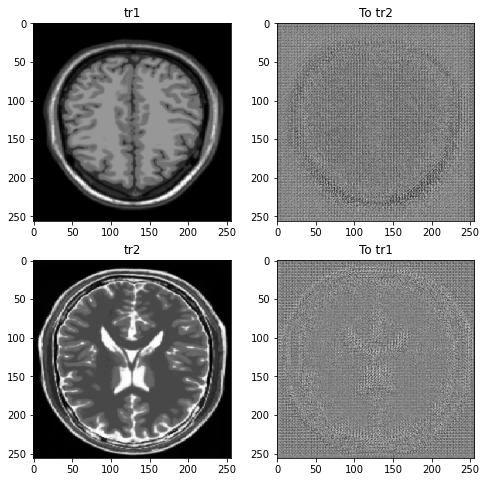

In [ ]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

### Model Training
1. Loss Functions
6. Optimizer
7. Checkpoint Initialization
8. Training Flow

#### Loss Funtions

In [ ]:
# Weight of the cycle consistency loss
LAMBDA = 10 

In [ ]:
# declare loss type here
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# Calculate the discriminator loss inside this function
def discriminator_loss(real, generated):
    # define real and fake loss using loss object
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [ ]:
# calculate generator loss inside this function
def generator_loss(generated):
    # use loss_obj loss type to define generator loss
    return loss_obj(tf.ones_like(generated), generated)

In [ ]:
# define the cycle consistency loss
def calc_cycle_loss(real_image, cycled_image):
    # take a mean absolute difference between real and cycled image to calculate cycle consistency loss
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [ ]:
# define the identity loss here
def identity_loss(real_image, same_image):
    # take a mean absolute difference between real and same image to calculate cycle consistency loss
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

#### Optimizers

In [ ]:
# declare optimizers for all the four models here
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### Checkpoint Initialization

In [ ]:
# declare number of epochs
EPOCHS = 500

In [ ]:
# path to store checkpoints
checkpoint_path = "/Users/ssahu/Downloads/UG/GAN/Trained_Model"

# initialize checkpoint object with all the optimizers and models
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

# initialize checkpoint manager
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
# function for displaying images
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

#### Training Flow

In [ ]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        # calculate discriminator predictions for both discriminators on real and fake data
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the generator loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        # calculate cycle loss for both the cycles
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # calculate discriminator loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

#### Train the CycleGAN Model for several Epochs

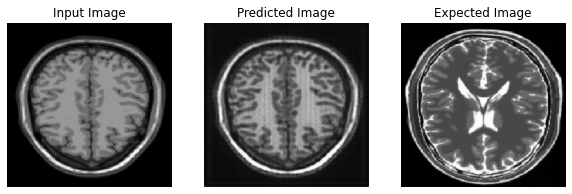

Saving checkpoint for epoch 0 at /Users/ssahu/Downloads/UG/GAN/Trained_Model/ckpt-1


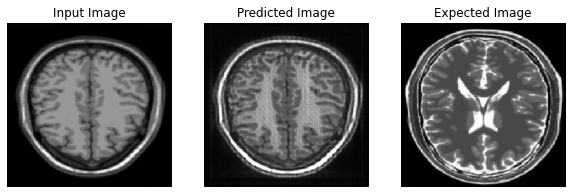

Saving checkpoint for epoch 1 at /Users/ssahu/Downloads/UG/GAN/Trained_Model/ckpt-2


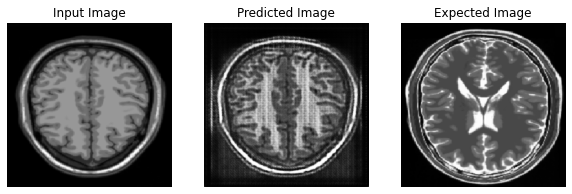

Saving checkpoint for epoch 2 at /Users/ssahu/Downloads/UG/GAN/Trained_Model/ckpt-3


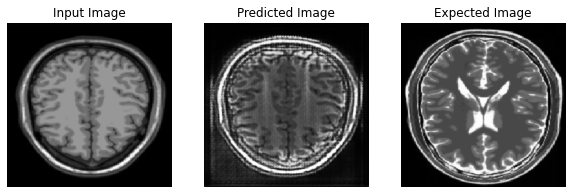

Saving checkpoint for epoch 3 at /Users/ssahu/Downloads/UG/GAN/Trained_Model/ckpt-4


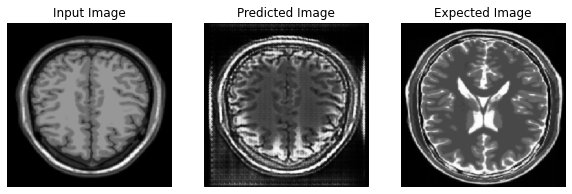

Saving checkpoint for epoch 4 at /Users/ssahu/Downloads/UG/GAN/Trained_Model/ckpt-5


KeyboardInterrupt: 

In [ ]:
# loop for the number of epochs
for epoch in range(EPOCHS):
    # for each image in both datasets, we train our model
    # remember that our batch size was 1 while loading the data
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    
    generate_images(generator_g, sample_tr1, sample_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

### Model Predictions

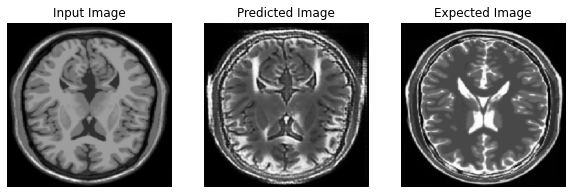

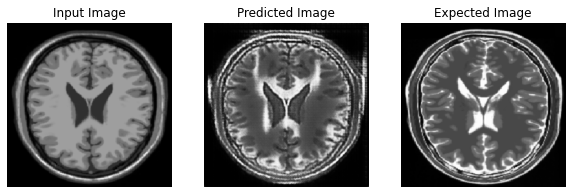

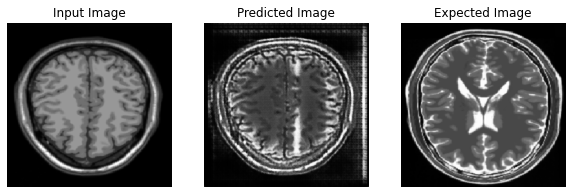

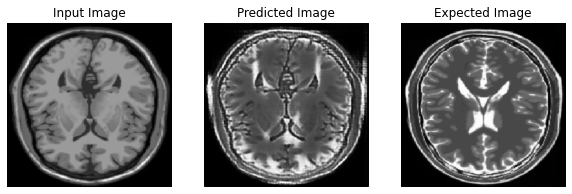

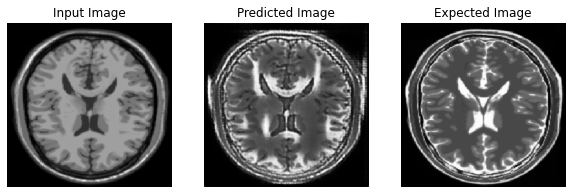

In [ ]:
# Run the trained model on the test dataset
for inp in tr1.take(5):
    generate_images(generator_g, inp, sample_tr2)